# Урок 4 Задание 1

*В наших данных использования ленты новостей есть два типа юзеров: те, кто пришел через платный трафик source = 'ads', и те, кто пришел через органические каналы source = 'organic'. Ваша задача — проанализировать и сравнить Retention этих двух групп пользователей. Решением этой задачи будет ответ на вопрос: отличается ли характер использования приложения у этих групп пользователей. В качестве ответа вы можете приложить ссылки на Superset, Redash или merge request в Gitlab, а также небольшое текстовое пояснение полученных результатов.*

NB! Здесь будет рассмотрен период с 1 по 31 декабря 2022 года

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }
# запрос на формирование пользователей от платного трафика с 1 по 31 декабря 2022 года
query = '''
SELECT toString(start_day) start_day,
       toString(day) day,
                     count(user_id) AS users
FROM
  (SELECT *
   FROM
     (SELECT user_id,
             min(toDate(time)) AS start_day
      FROM simulator_20221220.feed_actions
       WHERE source = 'ads'
      GROUP BY user_id) t1
   JOIN
     (SELECT DISTINCT user_id,
                      toDate(time) AS day
      FROM simulator_20221220.feed_actions WHERE source = 'ads') t2 USING user_id
   WHERE start_day BETWEEN '2022-12-01' AND '2022-12-31' AND day BETWEEN '2022-12-01' AND '2022-12-31')
GROUP BY start_day,
         day
ORDER BY start_day, day
'''

# запрос на формирование пользователей от орг. каналов с 1 по 31 декабря 2022 года
query2 = '''
SELECT toString(start_day) start_day,
       toString(day) day,
                     count(user_id) AS users
FROM
  (SELECT *
   FROM
     (SELECT user_id,
             min(toDate(time)) AS start_day
      FROM simulator_20221220.feed_actions
       WHERE source = 'organic'
      GROUP BY user_id) t1
   JOIN
     (SELECT DISTINCT user_id,
                      toDate(time) AS day
      FROM simulator_20221220.feed_actions WHERE source = 'organic') t2 USING user_id
   WHERE start_day BETWEEN '2022-12-01' AND '2022-12-31' AND day BETWEEN '2022-12-01' AND '2022-12-31')
GROUP BY start_day,
         day
ORDER BY start_day, day
'''

# платный трафик
ads = ph.read_clickhouse(query, connection=connection)

# органические каналы
organic = ph.read_clickhouse(query2, connection=connection)

In [3]:
ads.head()

,start_day,day,users
0,2022-12-01,2022-12-01,792
1,2022-12-01,2022-12-02,245
2,2022-12-01,2022-12-03,196
3,2022-12-01,2022-12-04,197
4,2022-12-01,2022-12-05,182


In [4]:
organic.tail()

,start_day,day,users
491,2022-12-29,2022-12-30,233
492,2022-12-29,2022-12-31,248
493,2022-12-30,2022-12-30,675
494,2022-12-30,2022-12-31,200
495,2022-12-31,2022-12-31,928


In [5]:
# создадим функцию, которая будет считать retention пользователей (с делением на когорты) - флэшбек с финального проекта по DA =)
def calculate_retention_rate(df):
    grouped = df.groupby(['start_day', 'day'])
    cohorts = grouped.agg({'users': 'sum'})
    
    def cohort_period(df):
        df['day'] = np.arange(len(df))
        return df
    
    cohorts = cohorts.groupby(level=0).apply(cohort_period)
    cohort_group_size = cohorts['users'].groupby(level=0).first()
    user_retention = cohorts['users'].unstack(0).divide(cohort_group_size, axis=1)
    return user_retention

<AxesSubplot:title={'center':'Heatmap of User Retention Rate - Ads'}, xlabel='day', ylabel='start_day'>

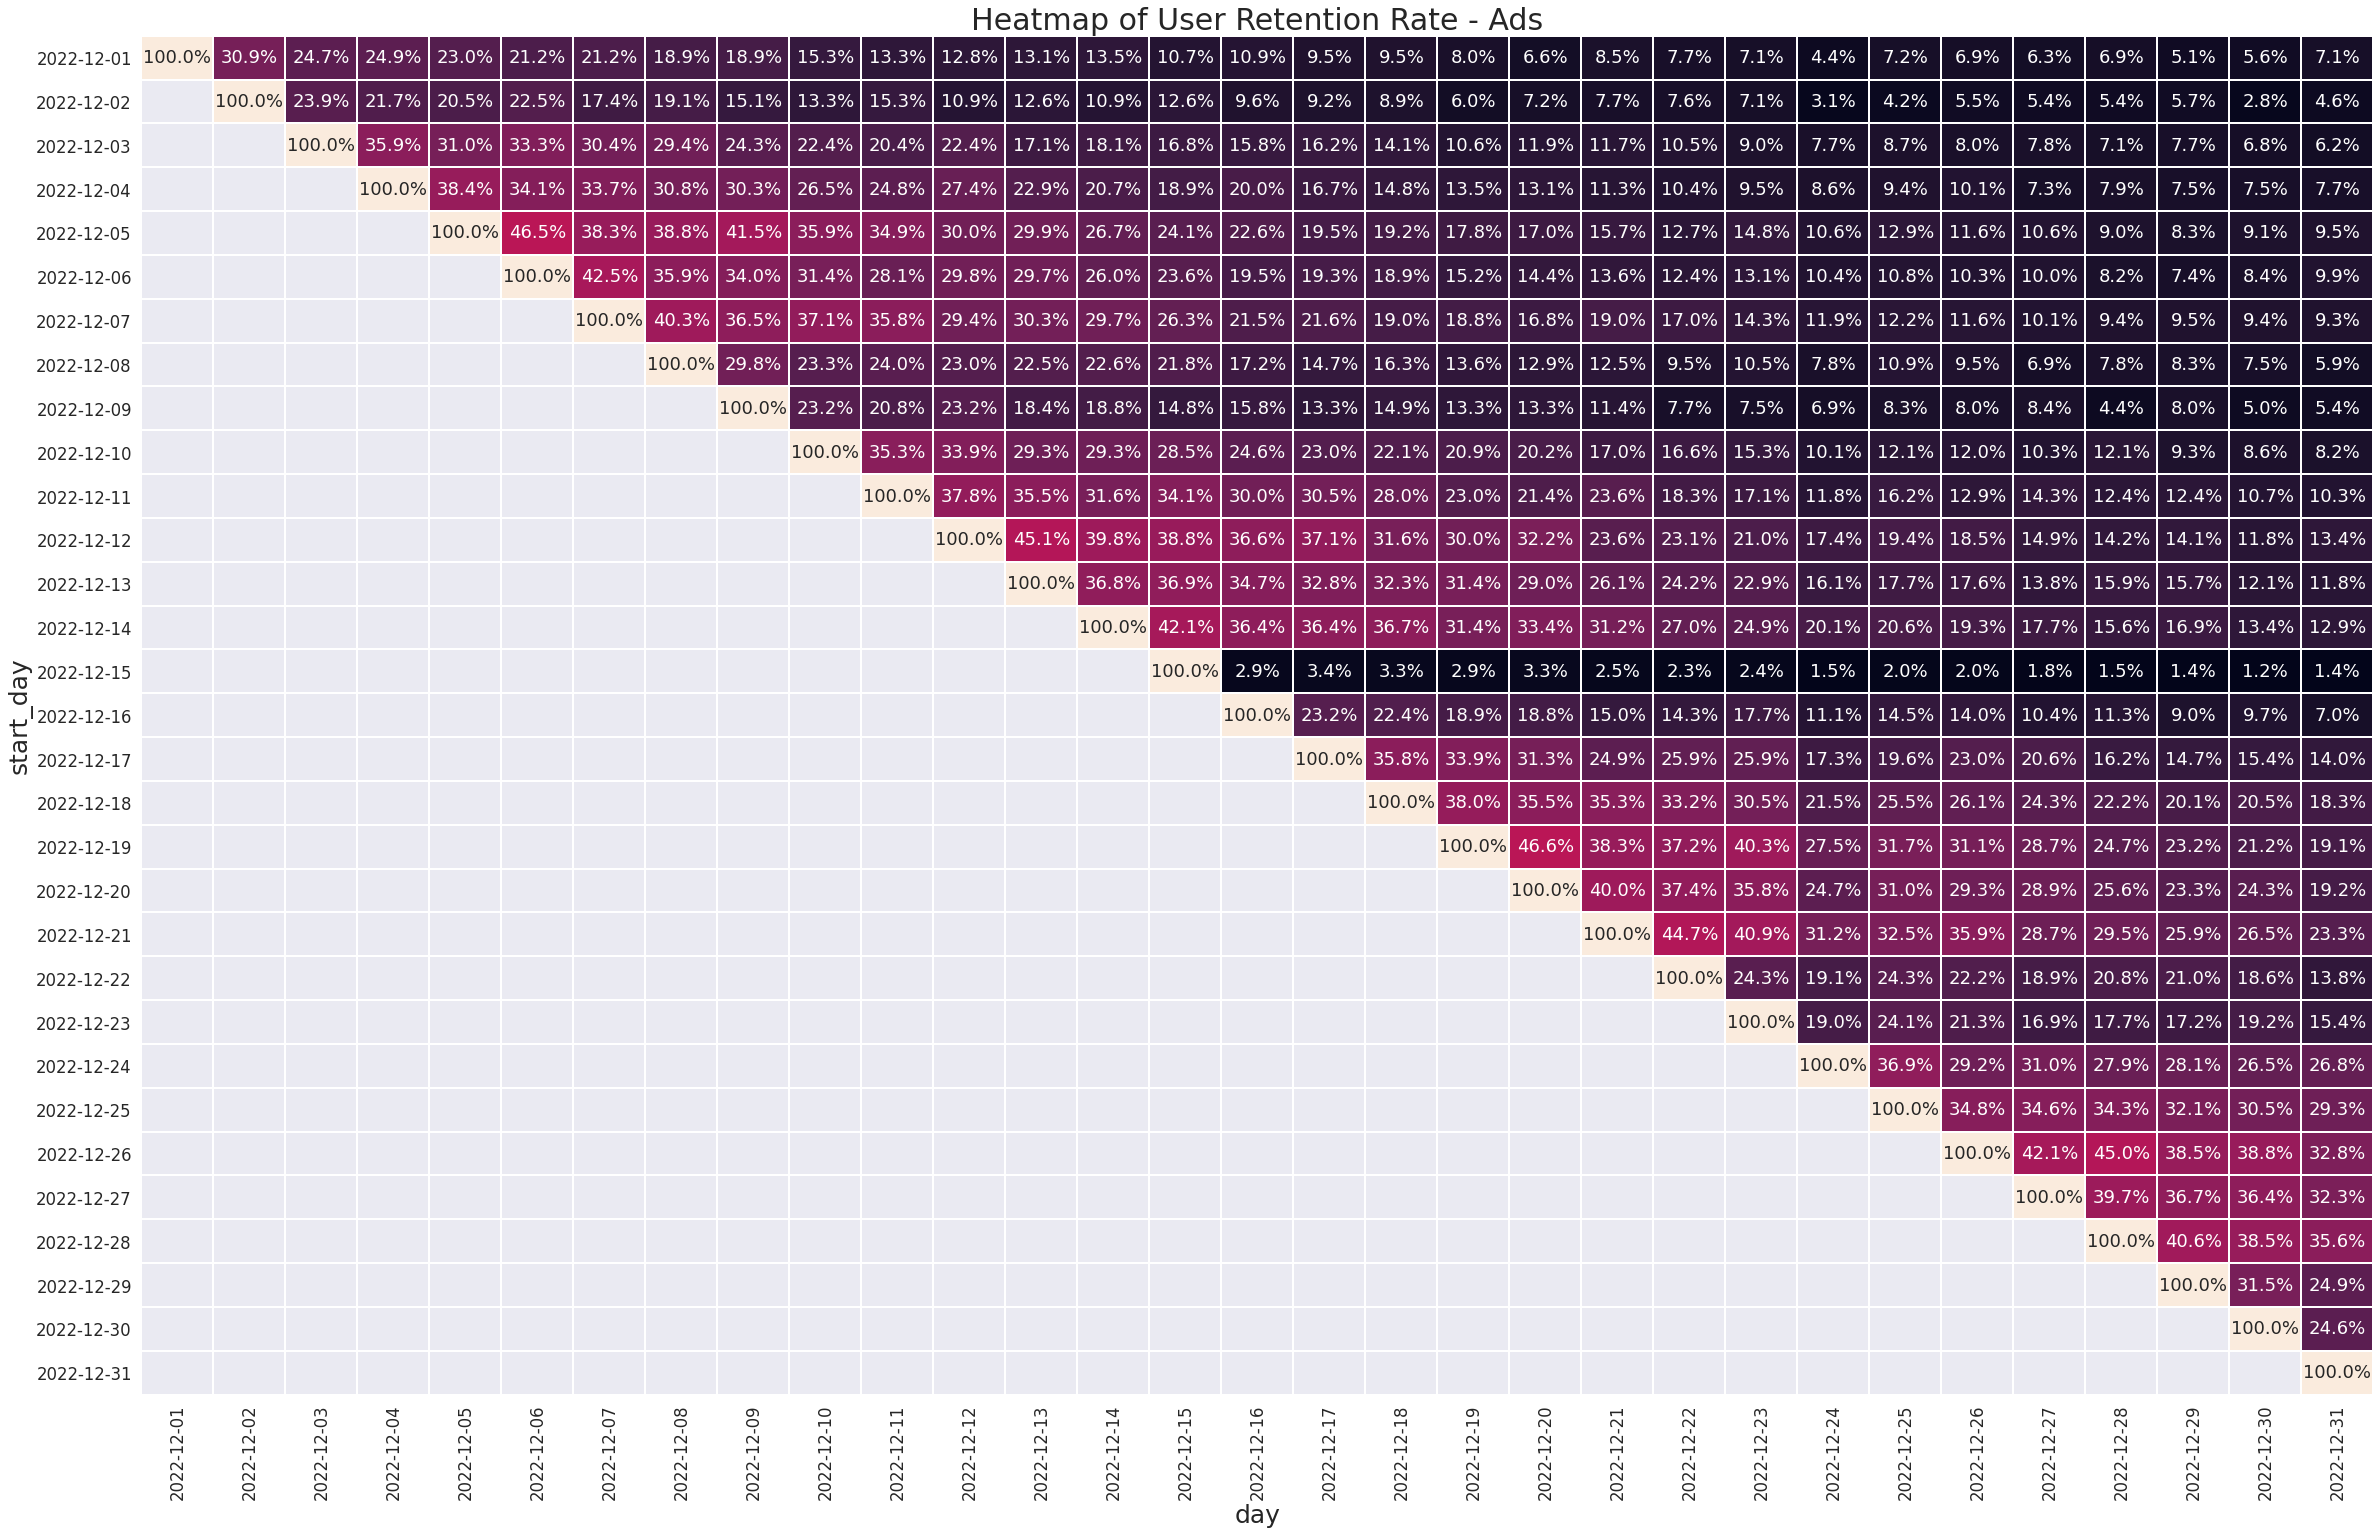

In [6]:
# heatmap для платного трафика
ads_ur = calculate_retention_rate(ads)
sns.set(style='ticks')
sns.set(font_scale=1.5)
plt.figure(figsize=(40, 25))
plt.title('Heatmap of User Retention Rate - Ads', fontsize=30)
plt.xlabel('Day', fontsize=25)
plt.ylabel('Registration Date', fontsize=25)
sns.heatmap(ads_ur.T, mask=ads_ur.T.isnull(), annot=True, fmt='.1%', linewidths=0.1, cbar=False)

<AxesSubplot:title={'center':'Heatmap of User Retention Rate - Organic'}, xlabel='day', ylabel='start_day'>

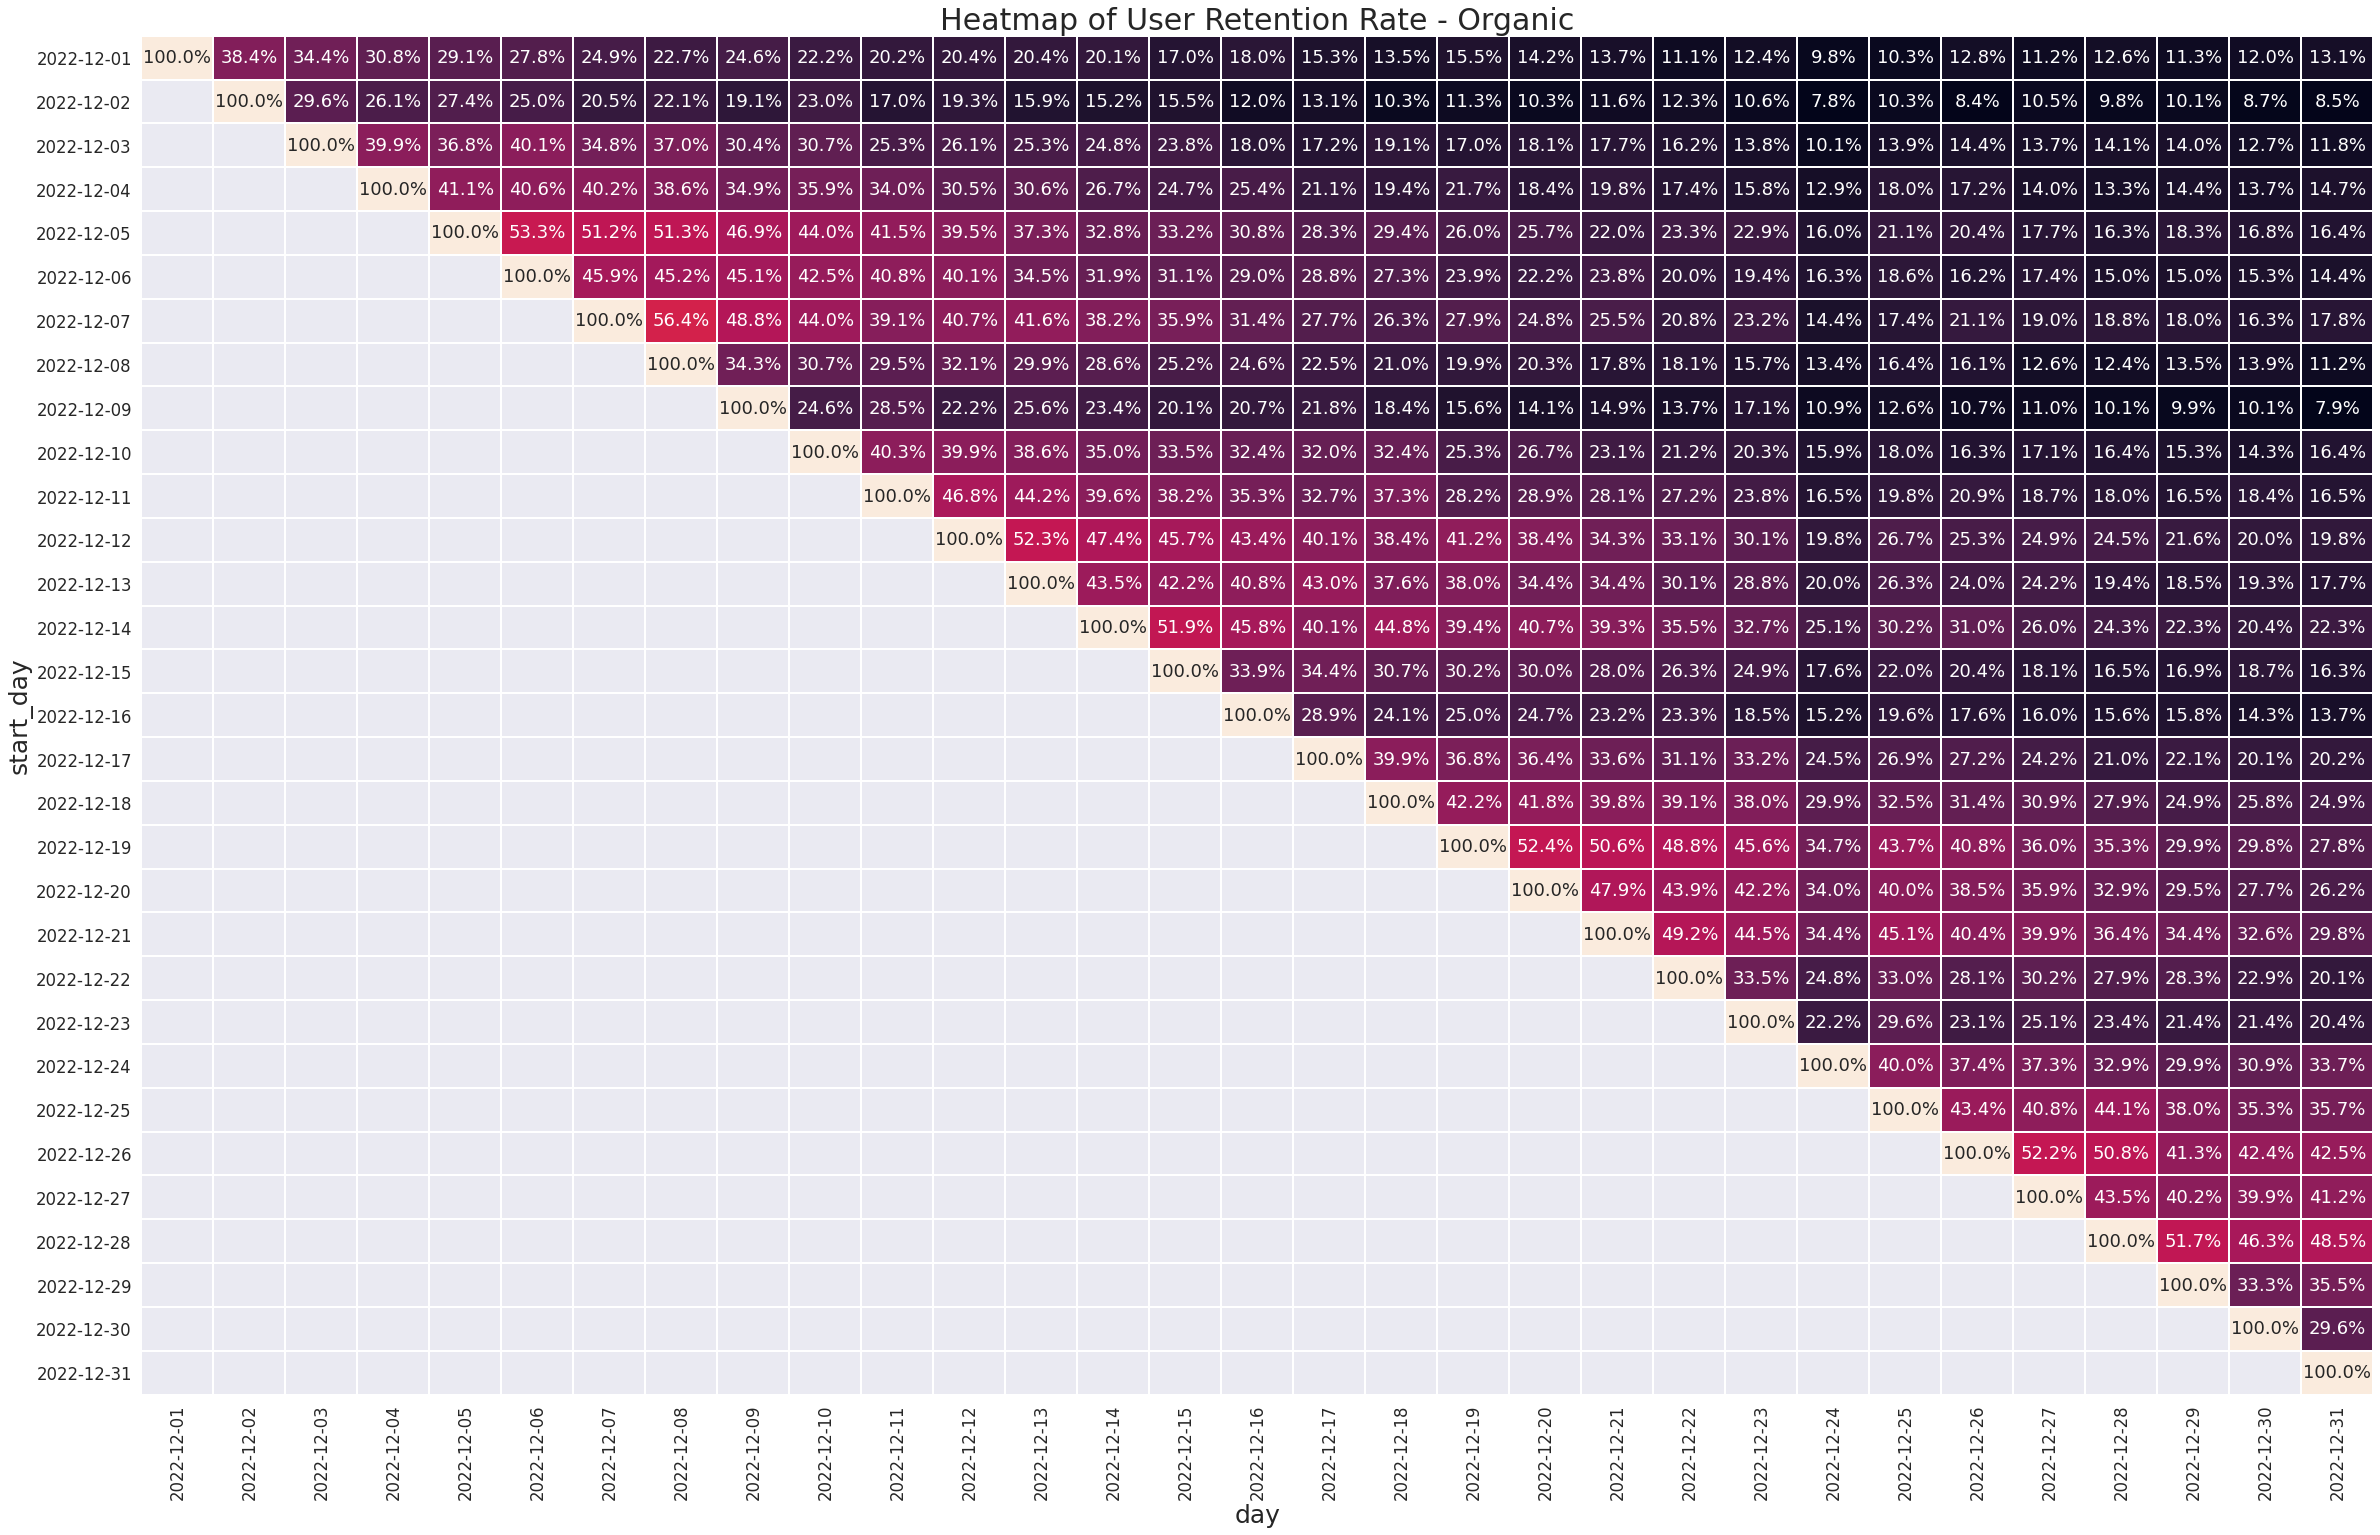

In [7]:
# heatmap для органических каналов
organic_ur = calculate_retention_rate(organic)
sns.set(style='ticks')
sns.set(font_scale=1.5)
plt.figure(figsize=(40, 25))
plt.title('Heatmap of User Retention Rate - Organic', fontsize=30)
plt.xlabel('Day', fontsize=25)
plt.ylabel('Registration Date', fontsize=25)
sns.heatmap(organic_ur.T, mask=organic_ur.T.isnull(), annot=True, fmt='.1%', linewidths=0.1, cbar=False)

## Выводы

1) Для платного трафика максимальный ретеншн 1 дня составил 46.6%, минимальный - 2.9%; для органических каналов максимальный ретеншн 1 дня составил 56.4%, минимальный - 22.2%.

2) Когорта от 15 декабря 2022 года в платном трафике сильно выделяется падением до 2.9% на 1 день. У органических каналов такого катастрофического падения не замечено ни разу за период от 1 по 31 декабря 2022.

3) В целом retention у organic будет повыше (в большинстве случаев  на ~5-10%). Т.е. пользователи, которые пришли через платный трафик, "возвращаются" в приложение немного менее активно, чем пришешдшие с органических каналов.